In [2]:
import pyefd
import pandas as pd
import numpy as np
from scipy.ndimage import rotate
from skimage.measure import find_contours
import matplotlib.pyplot as plt

In [20]:
shift_df = pd.read_csv("fftcoefs/shift_error_meta_fft128.csv").T
shift_df.columns = ["theta","centroid_x","centroid_y","error_c","error_n"]
shift_df = shift_df.iloc[1:,:]
shift_df.head(5)

,theta,centroid_x,centroid_y,error_c,error_n
/data/2Dshapespace/U-2_OS/cell_masks/320_D5_1_19.npy,99.83356396420712,(254.61379802188316,495.84824428053975),3.4740349256952223,1.5364878407405678
/data/2Dshapespace/U-2_OS/cell_masks/860_B8_2_5.npy,352.33319573818585,(198.60267099887713,361.4488138184772),3.0369608642823684,0.8112217676501043
/data/2Dshapespace/U-2_OS/cell_masks/73_B3_1_8.npy,138.65222278030632,(415.61974127162244,464.0807520484428),5.236913409866633,4.347824270003295
/data/2Dshapespace/U-2_OS/cell_masks/1607_F2_1_4.npy,213.3885135761115,(324.45873479621224,353.93071009717994),3.471875569907269,3.3469282509726668
/data/2Dshapespace/U-2_OS/cell_masks/476_E11_1_5.npy,346.4295656148385,(405.8923982425599,550.0682914697836),7.1382871991581,1.8539891089380907


In [ ]:
nuc_contours = []
cell_contours = []

for i,r in shift_df.iterrows():
    img_path = f"cell_masks/{i.split('/')[-1]}"
    img = np.load(img_path)
    theta = float(r["theta"])
    centroid_x = float(r["centroid_x"].split("(")[1])
    centroid_y = float(r["centroid_y"].split(")")[0])
    
    nuc_rot = rotate(img[1,:,:], theta)
    nuc_contour = find_contours(nuc_rot)
    nuc_contour = nuc_contour - np.array((centroid_x, centroid_y))
    nuc_contours.append(nuc_contour)
    
    cell_rot = rotate(img[0,:,:], theta)
    cell_contour = find_contours(cell_rot)
    if len(cell_contour) > 1:
        cell_contour = np.vstack(cell_contour)
    cell_contour = cell_contour - np.array((centroid_x, centroid_y))
    cell_contours.append(cell_contour)

In [69]:
n_terms = 128

In [89]:
%%time

recon_nuc_contours = []
recon_nuc_errs = []

for i,xy in enumerate(nuc_contours):
    if len(xy.shape) > 2:
        xy = xy.squeeze()
    n_points = xy.shape[0]
    coeffs = pyefd.elliptic_fourier_descriptors(xy, order=n_terms)
    a0, c0 = pyefd.calculate_dc_coefficients(xy)

    dxy = np.diff(xy, axis=0)
    dxy = np.insert(dxy, 0, [0,0]).reshape(xy.shape[0],2)
    dt = np.sqrt((dxy ** 2).sum(axis=1))
    arcl = np.cumsum(dt)
    T = arcl[-1]
    t_orig = (2 * np.pi * arcl) / T

    t = np.linspace(0, 1.0, n_points)
    t_approx = t*2*np.pi

    xt = np.ones((n_points,)) * a0
    yt = np.ones((n_points,)) * c0

    for terms in range(n_terms):
        xt += (coeffs[terms, 0] * np.cos(2 * (terms + 1) * np.pi * t)) + (
            coeffs[terms, 1] * np.sin(2 * (terms + 1) * np.pi * t)
        )
        yt += (coeffs[terms, 2] * np.cos(2 * (terms + 1) * np.pi * t)) + (
            coeffs[terms, 3] * np.sin(2 * (terms + 1) * np.pi * t)
        )
    recon_err = (np.average(abs(xy[:,0] - xt)) + np.average(abs(xy[:,1] - yt))) / 2
    recon_nuc_contours.append([xt,yt])
    recon_nuc_errs.append(recon_err)

CPU times: user 51.5 s, sys: 15.9 ms, total: 51.5 s
Wall time: 51.6 s


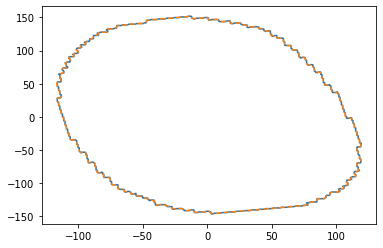

In [112]:
plt.plot(nuc_contours[0].squeeze()[:,0], nuc_contours[0].squeeze()[:,1])
plt.plot(recon_nuc_contours[0][0], recon_nuc_contours[0][1], "--")

In [104]:
list(shift_df["error_n"].values)

['1.5364878407405678',
 '0.8112217676501043',
 '4.347824270003295',
 '3.3469282509726668',
 '1.8539891089380907',
 '0.900406692747481',
 '2.040774441604918',
 '1.2186676055809031',
 '0.4736457438457904',
 '3.165551827506631',
 '1.710524492998816',
 '1.4484967701074993',
 '0.6770607702842733',
 '0.4248746098540559',
 '0.8096788763642676',
 '1.299715032483943',
 '1.226953246211108',
 '1.2294938431572446',
 '1.4349154721798278',
 '0.8344754862331758',
 '1.2536150636645709',
 '2.0655372769430502',
 '2.5060585423631174',
 '1.1396151597478896',
 '1.9181632600077274',
 '1.4606131957799167',
 '1.2401385153760445',
 '0.6347016858722418',
 '0.9815548991616561',
 '1.608944653937899',
 '1.6543967564838211',
 '1.5402720379222032',
 '2.150398080708719',
 '2.6727851040358717',
 '2.6753982638105995',
 '1.2528864048383044',
 '1.7973957572958086',
 '1.896736922055228',
 '1.7762257503395356',
 '4.142999967526012',
 '0.6820112527748107',
 '5.252043167137499',
 '1.760875912086246',
 '2.4101589539646207',
 

In [90]:
recon_nuc_errs

[0.4062570051888329,
 0.47594669021424074,
 0.5080965551764894,
 0.6897093541814727,
 1.0372735266973196,
 0.3462167547527226,
 1.0756597429670345,
 0.24544483309400802,
 0.5327657587027709,
 0.6364641531541351,
 0.894690682222708,
 0.4773659710569471,
 0.2702325441413641,
 0.4879122836081783,
 0.8232414608468583,
 0.817610112675897,
 0.8757890361844198,
 0.7277108907745979,
 0.35066157054754776,
 0.6821680534336596,
 0.3825595882199757,
 0.49229723939866504,
 0.6122023030956827,
 0.572993803827161,
 0.7935017399865625,
 1.0699623286167217,
 0.45095893685569355,
 0.3071426648514391,
 0.42349680246654864,
 0.903148784239471,
 0.4733663159543092,
 0.45103203468690356,
 0.6227671321420148,
 0.4484354324305447,
 0.737206256831654,
 0.5763746283798171,
 1.4345826281951162,
 0.4815946021195395,
 1.113359158954641,
 0.6028208979440425,
 0.9328908011797121,
 0.9423689455640722,
 1.9009930680021334,
 0.2781268220974574,
 0.5442718841958707,
 0.48840123225933607,
 0.5476152933041347,
 0.36528262

In [103]:
%%time

recon_cell_contours = []
recon_cell_errs = []

for i,xy in enumerate(cell_contours):
    if len(xy.shape) > 2:
        xy = xy.squeeze()
    n_points = xy.shape[0]
    coeffs = pyefd.elliptic_fourier_descriptors(xy, order=n_terms)
    a0, c0 = pyefd.calculate_dc_coefficients(xy)

    dxy = np.diff(xy, axis=0)
    dxy = np.insert(dxy, 0, [0,0]).reshape(xy.shape[0],2)
    dt = np.sqrt((dxy ** 2).sum(axis=1))
    arcl = np.cumsum(dt)
    T = arcl[-1]
    t_orig = (2 * np.pi * arcl) / T

    t = np.linspace(0, 1.0, n_points)
    t_approx = t*2*np.pi

    xt = np.ones((n_points,)) * a0
    yt = np.ones((n_points,)) * c0

    for terms in range(n_terms):
        xt += (coeffs[terms, 0] * np.cos(2 * (terms + 1) * np.pi * t)) + (
            coeffs[terms, 1] * np.sin(2 * (terms + 1) * np.pi * t)
        )
        yt += (coeffs[terms, 2] * np.cos(2 * (terms + 1) * np.pi * t)) + (
            coeffs[terms, 3] * np.sin(2 * (terms + 1) * np.pi * t)
        )
    recon_err = (np.average(abs(xy[:,0] - xt)) + np.average(abs(xy[:,1] - yt))) / 2
    recon_cell_contours.append([xt,yt])
    recon_cell_errs.append(recon_err)

CPU times: user 1min 55s, sys: 56 ms, total: 1min 56s
Wall time: 1min 56s


In [105]:
list(shift_df["error_c"].values)

['3.4740349256952223',
 '3.0369608642823684',
 '5.236913409866633',
 '3.471875569907269',
 '7.1382871991581',
 '3.8621979045930703',
 '8.631978524513123',
 '2.480410692443299',
 '7.0016722944434076',
 '4.92777779552982',
 '11.883106071741555',
 '3.6016380010226965',
 '2.3331563592248052',
 '0.6893983777030089',
 '3.1334609222838163',
 '5.2506539913834125',
 '4.8039952787615565',
 '7.804411967888813',
 '6.017935553520658',
 '3.796481050866923',
 '1.838235965028463',
 '4.545396206728829',
 '3.205350025637899',
 '2.544219266660013',
 '22.42500150702637',
 '4.747098135768501',
 '3.428968514003547',
 '0.9597474481725239',
 '1.5292430103280408',
 '3.512761277116855',
 '5.081696568012092',
 '2.8467894550768653',
 '5.541412311705864',
 '26.517857024359106',
 '7.691073734505631',
 '3.0082162495335094',
 '14.14322351608753',
 '14.941909827293804',
 '11.839384971279593',
 '12.447200318275316',
 '7.369156241477588',
 '7.27902220041871',
 '2.3018639165663566',
 '3.747736457199303',
 '3.204235395958

In [106]:
recon_cell_errs

[6.64617064142092,
 5.20652094980138,
 2.356468826072424,
 1.670271321139257,
 2.8324644698358235,
 0.7967699723640307,
 13.113416727068905,
 2.3255488045102712,
 11.984239870462094,
 10.24883626860023,
 12.534756390096373,
 1.8037185825655455,
 1.7929292634885254,
 0.9516158677080057,
 3.3334980019066602,
 3.2805696012099097,
 14.487302409327095,
 3.926654784856113,
 1.4743984417034806,
 2.373327825248153,
 0.7455747076178338,
 1.3770260492389639,
 5.185677076929327,
 8.463075505638296,
 246.7066379306519,
 4.135741759748312,
 1.098427733445528,
 1.3413736898592916,
 0.8680676179737428,
 2.756664497830937,
 5.552337368835568,
 2.918671210953964,
 2.343985647886856,
 11.802025687118729,
 7.04756810052322,
 4.615334515230364,
 7.913861975281588,
 6.439283859518776,
 66.71869002140616,
 7.784604800369923,
 7.075813853558523,
 3.9394846187836934,
 5.2861519940780255,
 1.965761322653624,
 2.1337126391495156,
 2.521921122127952,
 2.238622180909675,
 0.7541820517998595,
 5.583179381502353,
 

In [142]:
recon_cell_errs  = np.array(recon_cell_errs)

In [162]:
cell = np.load("cell_masks/1018_B1_4_7.npy")[0,:,:]

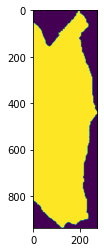

In [199]:
plt.imshow(cell)

In [211]:
cell_contour = find_contours(cell_padded, 0, fully_connected="high")

In [212]:
cell_contour = np.vstack(cell_contour)

In [213]:
cell_contour.shape

(2284, 2)

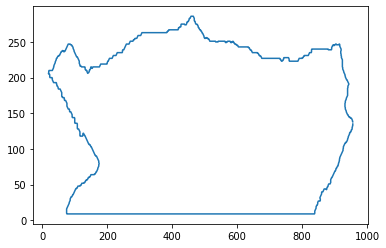

In [214]:
plt.plot(cell_contour[:,0], cell_contour[:,1])

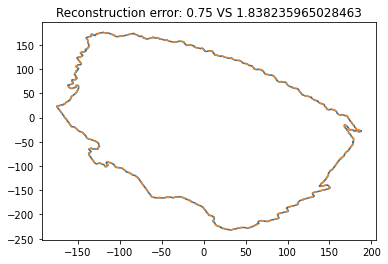

In [207]:
idx = 20
plt.title(f"Reconstruction error: {round(recon_cell_errs[idx],2)} VS {shift_df['error_c'][20]}")
plt.plot(cell_contours[idx].squeeze()[:,0], cell_contours[idx].squeeze()[:,1])
plt.plot(recon_cell_contours[idx][0], recon_cell_contours[idx][1], "--")